## Hands on lecture: train TFL net

 In this hands-on lecture, we will train a model for predicting Traffic-light (TFL) in image patches, you will use the data generated in previous course to this end.
 You will :
 1. Evaluate the data previously generated and ensure it's validity.
 2. Train a CNN 
 3. Evaluate results of the trained model.
 4. seek ways to improve results

In [13]:
%reload_ext autoreload
%autoreload 2
# %autosave 120
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt
from os.path import join

## Step 1. Validate your data
    use the example in the cell below, to verify the TFL patch you've generated is sane.
    Things to watch for:
    1. You are able to load and vizualize your train and val data, using the functions below.
    2. using the vizualization verify  image <--> label correspondence is correct.
    3. % Negative vs. Positive examples is aprroximately 50%
 

val :  (740, 81, 81, 3) 0/1 split 50.0 %
train :  (4574, 81, 81, 3) 0/1 split 50.0 %


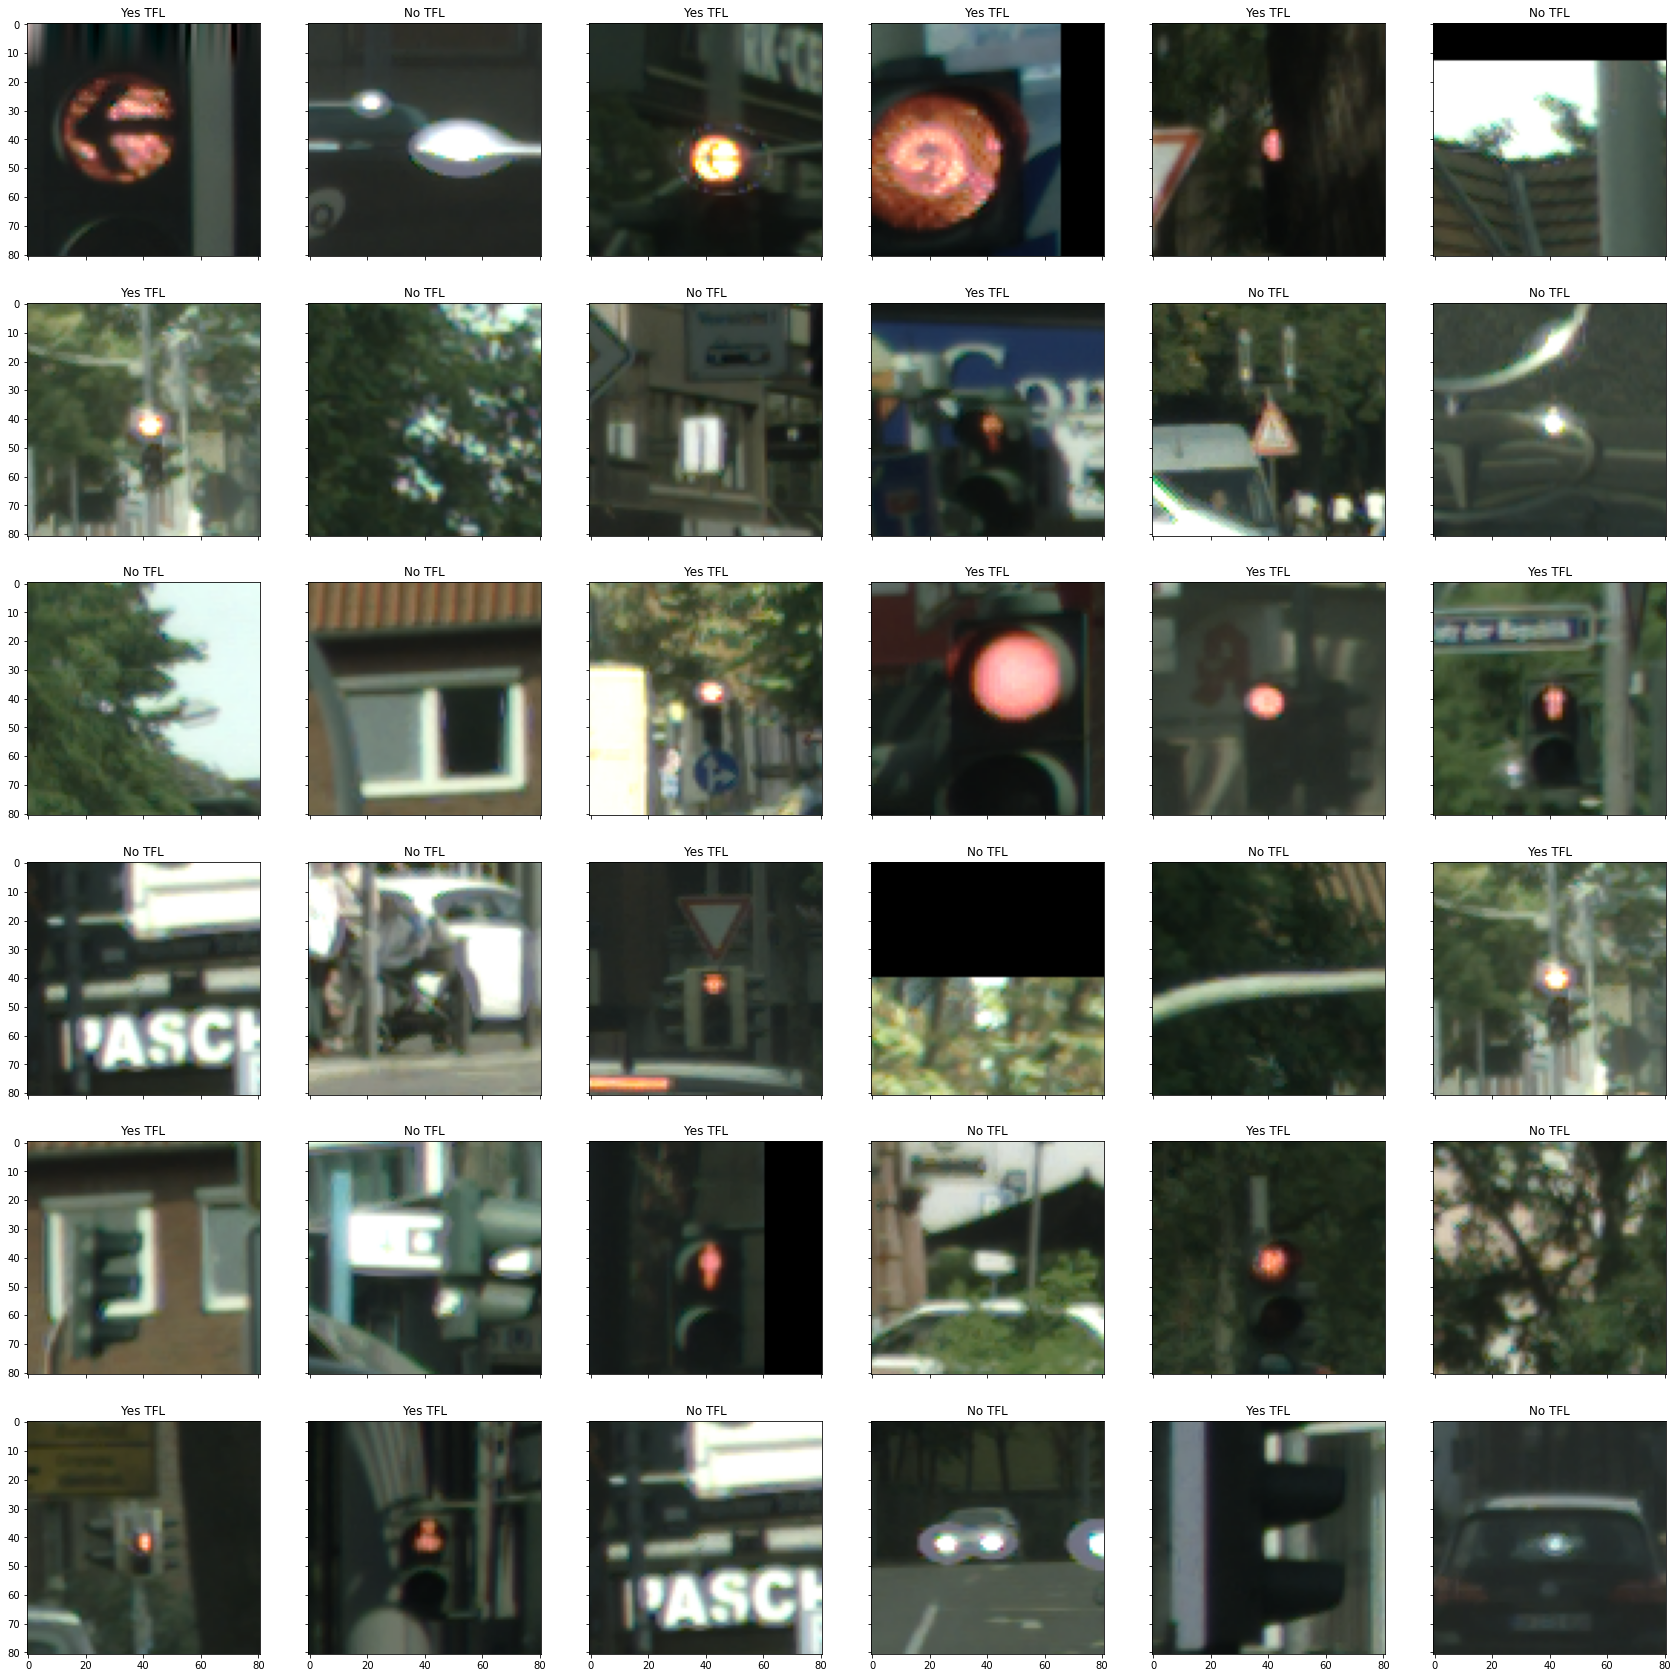

In [14]:
def load_tfl_data(data_dir, crop_shape=(81,81)):
    images = np.memmap(join(data_dir,'data.bin'),mode='r',dtype=np.uint8).reshape([-1]+list(crop_shape) +[3])
    labels = np.memmap(join(data_dir,'labels.bin'),mode='r',dtype=np.uint8)
    return {'images':images,'labels':labels}

def viz_my_data(images,labels, predictions=None, num=(5,5), labels2name= {0:'No TFL',1:'Yes TFL'}):
    assert images.shape[0] == labels.shape[0]
    assert predictions is None or predictions.shape[0] == images.shape[0]
    h = 5
    n = num[0]*num[1]
    ax = plt.subplots(num[0],num[1],figsize=(h*num[0],h*num[1]),gridspec_kw={'wspace':0.05},squeeze=False,sharex=True,sharey=True)[1]#.flatten()
    idxs = np.random.randint(0,images.shape[0],n)
    for i,idx in enumerate(idxs):
        ax.flatten()[i].imshow(images[idx])
        title = labels2name[labels[idx]]
        if predictions is not None : title += ' Prediction: {:.2f}'.format(predictions[idx])
        ax.flatten()[i].set_title(title)
   

# root = 'C:\לימודים\mobilye_project\cnn_min_course'  #this is the root for your val and train datasets
data_dir = 'C:\לימודים\mobilye_project\data_dir_good'
datasets = {
    'val':load_tfl_data(join(data_dir,'val')),
    'train': load_tfl_data(join(data_dir,'train')),
    }
for k,v in datasets.items():
    
    print ('{} :  {} 0/1 split {:.1f} %'.format(k,v['images'].shape, np.mean(v['labels']==1)*100))

viz_my_data(num=(6,6),**datasets['val'])   

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Activation,MaxPooling2D,BatchNormalization,Activation, Conv2D, Dropout

## define the model used for training


In [16]:




def tfl_model():
    input_shape =(81,81,3)
    
    model = Sequential()
    def conv_bn_relu(filters,**conv_kw):
        model.add(Conv2D(filters,  use_bias=True, kernel_initializer='he_normal',**conv_kw,  padding='SAME'))
#         model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
    def dense_bn_relu(units):
        model.add(Dense(units, use_bias=True,kernel_initializer='he_normal'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
    
    def spatial_layer(count, filters): 
        for i in range(count):
            conv_bn_relu(filters,kernel_size=(3,3))
        conv_bn_relu(filters, kernel_size=(3,3),strides=(2,2))
    
    conv_bn_relu(32,kernel_size=(3,3),input_shape=input_shape)
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.15))
    
    
    spatial_layer(1,32) 
    spatial_layer(2,32)
    spatial_layer(2,96)   
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.15))


              
              
    model.add(Flatten())
    dense_bn_relu(96)
    model.add(Dense(2, activation='softmax'))
    return model
m = tfl_model()
m.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 81, 81, 32)        896       
_________________________________________________________________
batch_normalization_20 (Batc (None, 81, 81, 32)        128       
_________________________________________________________________
activation_20 (Activation)   (None, 81, 81, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 40, 40, 32)        9248      
_________________________________________________________________
batch_normalization_21 (Batc (None, 40, 40, 32)       

## train

In [17]:
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
data_dir = 'C:\לימודים\mobilye_project\data_dir_good'
datasets = {
    'val':load_tfl_data(join(data_dir,'val')),
    'train': load_tfl_data(join(data_dir,'train')),
    }
#prepare our model
m = tfl_model()
m.compile(optimizer=Adam(),loss =sparse_categorical_crossentropy,metrics=['accuracy'])

train,val = datasets['train'],datasets['val']
#train it, the model uses the 'train' dataset for learning. We evaluate the "goodness" of the model, by predicting the label of the images in the val dataset.
history=m.fit(train['images'],train['labels'],validation_data=(val['images'],val['labels']),epochs = 15)

Train on 4574 samples, validate on 740 samples
Epoch 1/15
4574/4574 [==============================] - 159s 35ms/sample - loss: 0.5539 - acc: 0.7267 - val_loss: 0.5961 - val_acc: 0.7014
Epoch 2/15
4574/4574 [==============================] - 158s 34ms/sample - loss: 0.3951 - acc: 0.8207 - val_loss: 0.5436 - val_acc: 0.7189
Epoch 3/15
4574/4574 [==============================] - 146s 32ms/sample - loss: 0.3256 - acc: 0.8570 - val_loss: 0.3960 - val_acc: 0.8135
Epoch 4/15
4574/4574 [==============================] - 149s 33ms/sample - loss: 0.2750 - acc: 0.8839 - val_loss: 0.3537 - val_acc: 0.8338
Epoch 5/15
4574/4574 [==============================] - 155s 34ms/sample - loss: 0.2374 - acc: 0.8997 - val_loss: 0.3865 - val_acc: 0.8419
Epoch 6/15
4574/4574 [==============================] - 155s 34ms/sample - loss: 0.2099 - acc: 0.9147 - val_loss: 0.3751 - val_acc: 0.8392
Epoch 7/15
4574/4574 [==============================] - 158s 35ms/sample - loss: 0.1794 - acc: 0.9285 - val_loss: 0.424

In [19]:
def load_tfl_data(data_dir, crop_shape=(81,81)):
    images = np.memmap(join(data_dir,'flipped_data.bin'),mode='r',dtype=np.uint8).reshape([-1]+list(crop_shape) +[3])
    labels = np.memmap(join(data_dir,'labels.bin'),mode='r',dtype=np.uint8)
    return {'images':images,'labels':labels}


history=m.fit(train['images'],train['labels'],validation_data=(val['images'],val['labels']),epochs = 10)

Train on 4574 samples, validate on 740 samples
Epoch 1/10
4574/4574 [==============================] - 113s 25ms/sample - loss: 0.0605 - acc: 0.9773 - val_loss: 0.4651 - val_acc: 0.8527
Epoch 2/10
4574/4574 [==============================] - 115s 25ms/sample - loss: 0.0556 - acc: 0.9812 - val_loss: 0.5406 - val_acc: 0.8676
Epoch 3/10
4574/4574 [==============================] - 113s 25ms/sample - loss: 0.0615 - acc: 0.9764 - val_loss: 0.5325 - val_acc: 0.8595
Epoch 4/10
4574/4574 [==============================] - 113s 25ms/sample - loss: 0.0579 - acc: 0.9784 - val_loss: 0.6262 - val_acc: 0.8189
Epoch 5/10
4574/4574 [==============================] - 116s 25ms/sample - loss: 0.0370 - acc: 0.9888 - val_loss: 0.5173 - val_acc: 0.8554
Epoch 6/10
4574/4574 [==============================] - 112s 25ms/sample - loss: 0.0592 - acc: 0.9786 - val_loss: 0.5250 - val_acc: 0.8595
Epoch 7/10
4574/4574 [==============================] - 113s 25ms/sample - loss: 0.0505 - acc: 0.9786 - val_loss: 0.782

In [20]:
def load_tfl_data(data_dir, crop_shape=(81,81)):
    images = np.memmap(join(data_dir,'darken_data.bin'),mode='r',dtype=np.uint8).reshape([-1]+list(crop_shape) +[3])
    labels = np.memmap(join(data_dir,'labels.bin'),mode='r',dtype=np.uint8)
    return {'images':images,'labels':labels}


history=m.fit(train['images'],train['labels'],validation_data=(val['images'],val['labels']),epochs = 10)

Train on 4574 samples, validate on 740 samples
Epoch 1/10
4574/4574 [==============================] - 114s 25ms/sample - loss: 0.0419 - acc: 0.9871 - val_loss: 0.7227 - val_acc: 0.8662
Epoch 2/10
4574/4574 [==============================] - 114s 25ms/sample - loss: 0.0324 - acc: 0.9891 - val_loss: 0.7087 - val_acc: 0.8378
Epoch 3/10
4574/4574 [==============================] - 114s 25ms/sample - loss: 0.0385 - acc: 0.9875 - val_loss: 0.7076 - val_acc: 0.8432
Epoch 4/10
4574/4574 [==============================] - 114s 25ms/sample - loss: 0.0520 - acc: 0.9823 - val_loss: 0.6610 - val_acc: 0.8446
Epoch 5/10
4574/4574 [==============================] - 113s 25ms/sample - loss: 0.0291 - acc: 0.9895 - val_loss: 0.6760 - val_acc: 0.8405
Epoch 6/10
4574/4574 [==============================] - 114s 25ms/sample - loss: 0.0447 - acc: 0.9854 - val_loss: 0.6610 - val_acc: 0.8486
Epoch 7/10
4574/4574 [==============================] - 114s 25ms/sample - loss: 0.0292 - acc: 0.9897 - val_loss: 0.696

In [21]:
def load_tfl_data(data_dir, crop_shape=(81,81)):
    images = np.memmap(join(data_dir,'bright_data.bin'),mode='r',dtype=np.uint8).reshape([-1]+list(crop_shape) +[3])
    labels = np.memmap(join(data_dir,'labels.bin'),mode='r',dtype=np.uint8)
    return {'images':images,'labels':labels}


history=m.fit(train['images'],train['labels'],validation_data=(val['images'],val['labels']),epochs = 10)

Train on 4574 samples, validate on 740 samples
Epoch 1/10
4574/4574 [==============================] - 112s 25ms/sample - loss: 0.0329 - acc: 0.9869 - val_loss: 0.8895 - val_acc: 0.8338
Epoch 2/10
4574/4574 [==============================] - 115s 25ms/sample - loss: 0.0370 - acc: 0.9858 - val_loss: 0.6023 - val_acc: 0.8554
Epoch 3/10
4574/4574 [==============================] - 114s 25ms/sample - loss: 0.0286 - acc: 0.9904 - val_loss: 0.6356 - val_acc: 0.8568
Epoch 4/10
4574/4574 [==============================] - 114s 25ms/sample - loss: 0.0159 - acc: 0.9956 - val_loss: 0.9209 - val_acc: 0.8473
Epoch 5/10
4574/4574 [==============================] - 117s 26ms/sample - loss: 0.0132 - acc: 0.9958 - val_loss: 0.6973 - val_acc: 0.8459
Epoch 6/10
4574/4574 [==============================] - 127s 28ms/sample - loss: 0.0184 - acc: 0.9937 - val_loss: 0.7974 - val_acc: 0.8554
Epoch 7/10
4574/4574 [==============================] - 113s 25ms/sample - loss: 0.0387 - acc: 0.9880 - val_loss: 0.841

In [24]:
def load_tfl_data(data_dir, crop_shape=(81,81)):
    images = np.memmap(join(data_dir,'noise_data.bin'),mode='r',dtype=np.uint8).reshape([-1]+list(crop_shape) +[3])
    labels = np.memmap(join(data_dir,'labels.bin'),mode='r',dtype=np.uint8)
    return {'images':images,'labels':labels}


history=m.fit(train['images'],train['labels'],validation_data=(val['images'],val['labels']),epochs = 10)

Train on 4574 samples, validate on 740 samples
Epoch 1/10
4574/4574 [==============================] - 112s 25ms/sample - loss: 0.0306 - acc: 0.9875 - val_loss: 0.9566 - val_acc: 0.8203
Epoch 2/10
4574/4574 [==============================] - 112s 25ms/sample - loss: 0.0202 - acc: 0.9913 - val_loss: 0.6612 - val_acc: 0.8581
Epoch 3/10
4574/4574 [==============================] - 113s 25ms/sample - loss: 0.0231 - acc: 0.9913 - val_loss: 0.7422 - val_acc: 0.8514
Epoch 4/10
4574/4574 [==============================] - 112s 24ms/sample - loss: 0.0296 - acc: 0.9904 - val_loss: 0.6543 - val_acc: 0.8514
Epoch 5/10
4574/4574 [==============================] - 113s 25ms/sample - loss: 0.0207 - acc: 0.9917 - val_loss: 0.6895 - val_acc: 0.8568
Epoch 6/10
4574/4574 [==============================] - 113s 25ms/sample - loss: 0.0176 - acc: 0.9943 - val_loss: 0.8745 - val_acc: 0.8419
Epoch 7/10
4574/4574 [==============================] - 112s 25ms/sample - loss: 0.0142 - acc: 0.9950 - val_loss: 0.745

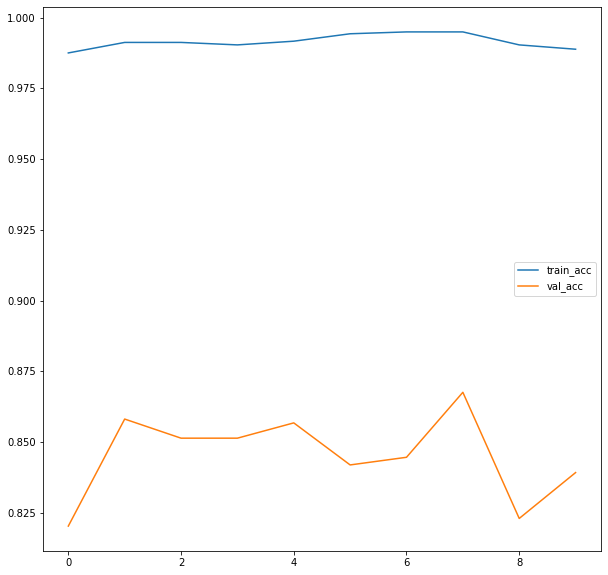

In [25]:
#compare train vs val acccuracy, 
# why is val_accuracy not as good as train accuracy? are we overfitting?
epochs = history.history
epochs['train_acc'] = epochs['acc']
plt.figure(figsize=(10,10))
for k in ['train_acc','val_acc']:
    plt.plot(range(len(epochs[k])), epochs[k],label=k)

plt.legend();

## evaluate and predict
Now thet we have a model we can use to predict results on the validation dataset.
1. What can say about example that fail prediction? can we find patterns that are common for failure cases?

accuracy: 0.8391891891891892


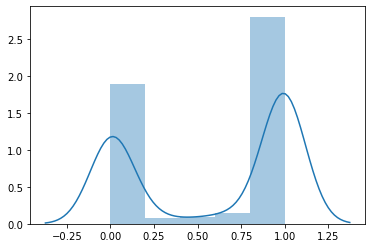

In [26]:
import seaborn as sbn
predictions = m.predict(val['images'])
sbn.distplot(predictions[:,0]);

predicted_label = np.argmax(predictions, axis=-1)
print ('accuracy:', np.mean(predicted_label==val['labels']))

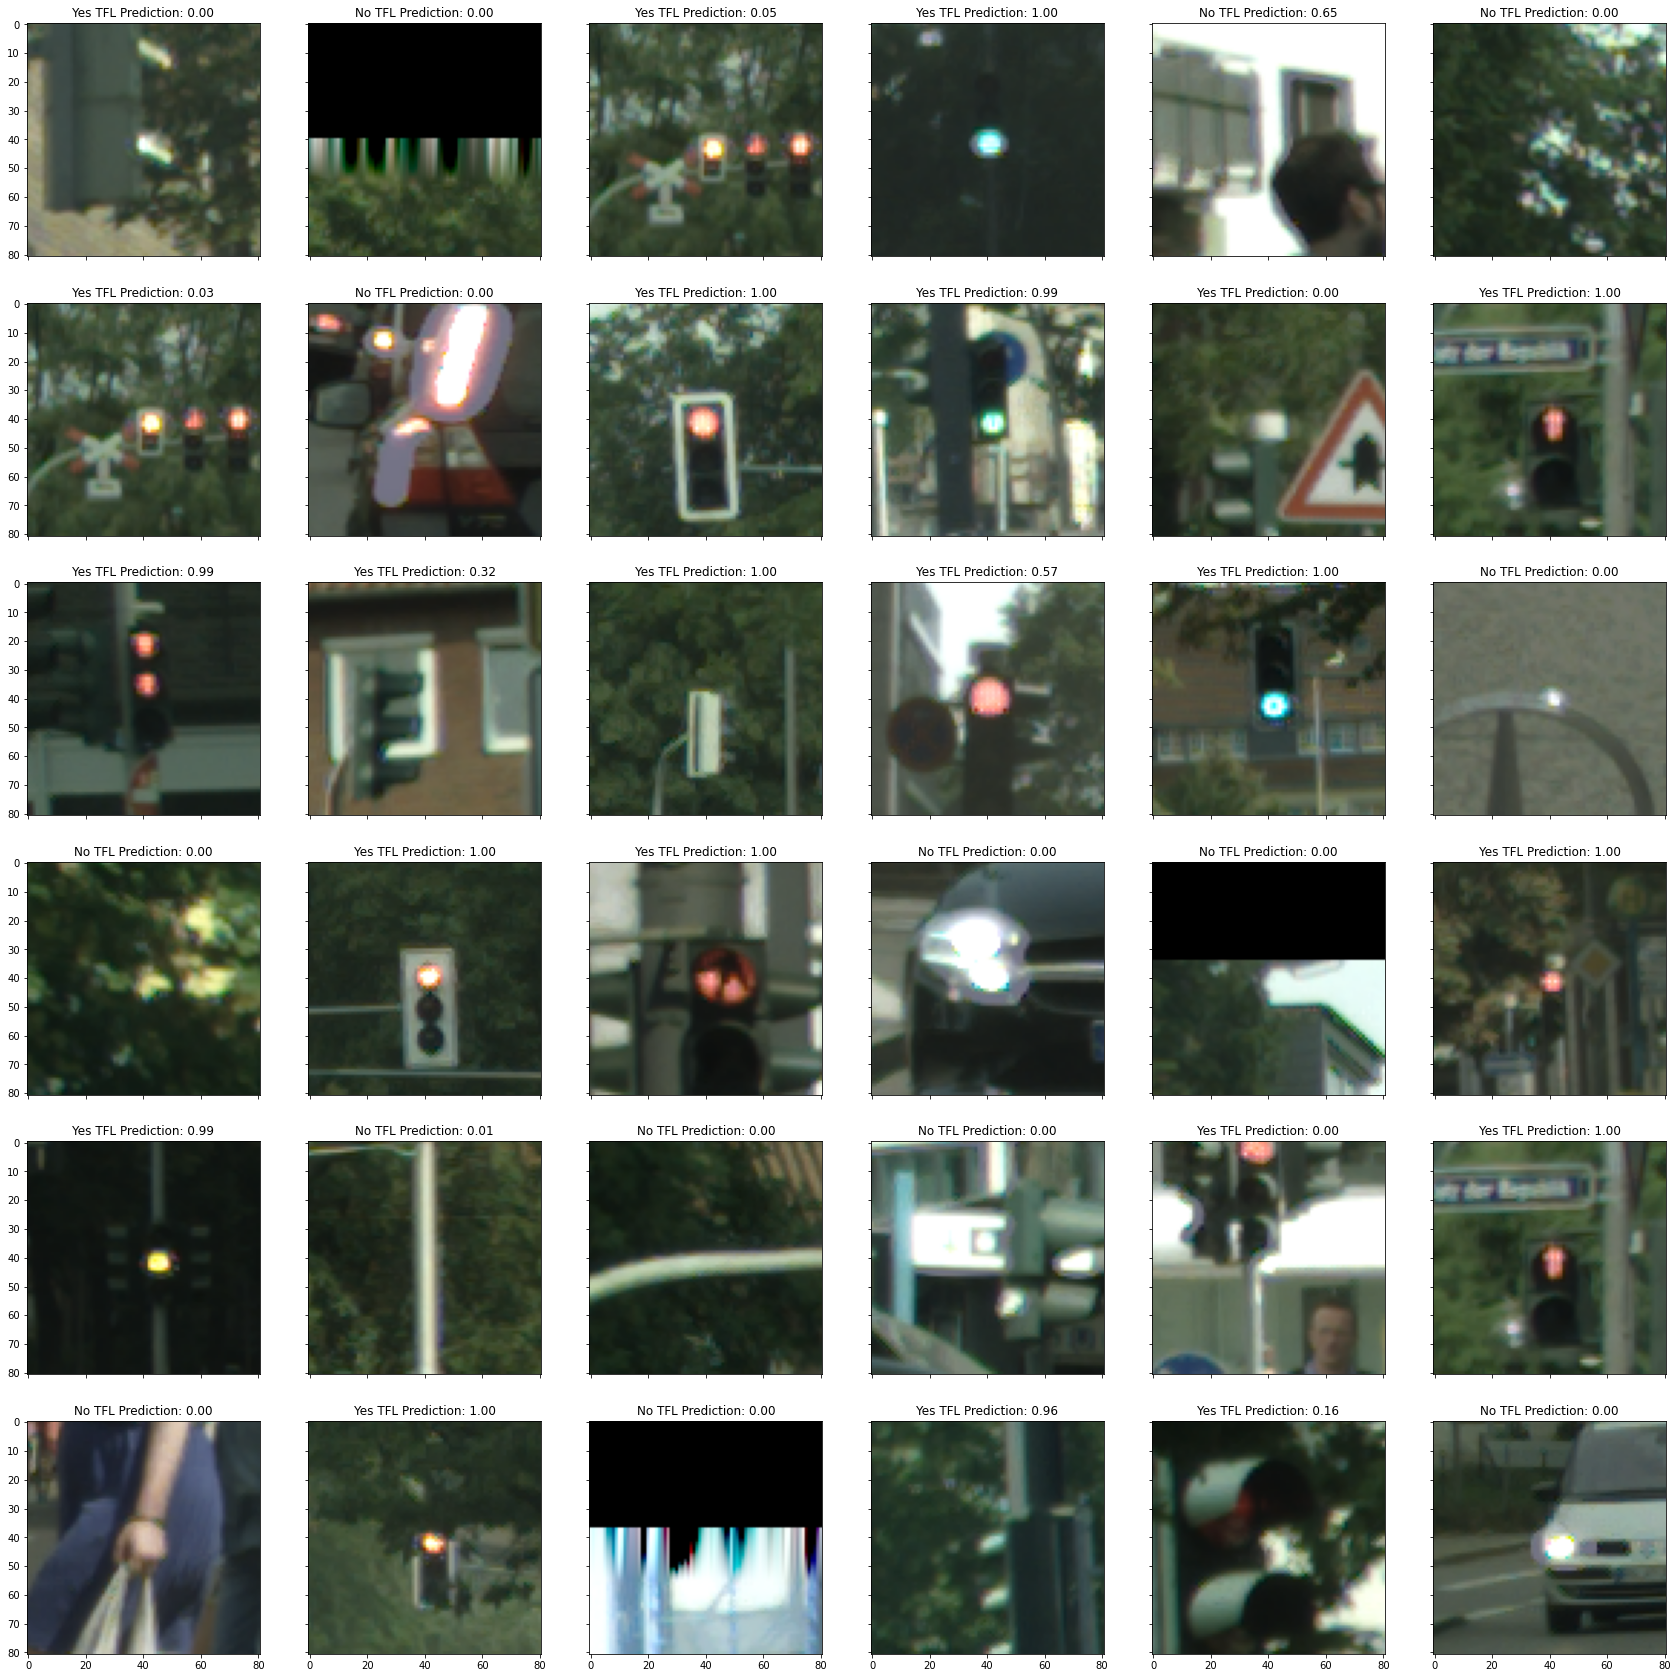

In [27]:
viz_my_data(num=(6,6),predictions=predictions[:,1],**val);

### Seek ways to improve resutls 
1. Try to play with diffferent models , increase / decrease the number of conv layers or number of  filters. you'll need to find a balanced model that is sufficiently large but minimzes overfit
    - try to enable tensorboard vizualization (see keras/ tensorboard doc) to help you carry the analysis
2. Data augmentation: feed your network with more examples by using data augmentation techniques: such as horizontal image flip, noise, etc

### Saving the model
After we trained our model and made predictions with it, we will now want to save the **architecture** together with its learned **weights** in order for us to be able to use it in the TFL manager.
The architecture will be saved as a json, the weights in the h5 format: 

In [33]:
m.save("model.h11")

In [29]:
# If you want to make sure that this model can be used on different operating systems and different
# versions of keras or tensorflow, this is the better way to save. For this project the simpler
# method above should work fine.

# json_filename = 'model.json'
# h5_filename   = 'weights.h5'
# # create a json with the model architecture
# model_json = m.to_json()
# # save the json to disk
# with open(json_filename, 'w') as f:
#     f.write(model_json)
# # save the model's weights:
# m.save_weights(h5_filename)
# print(" ".join(["Model saved to", json_filename, h5_filename]))

### Loading the model

In [32]:
from tensorflow.keras.models import load_model
loaded_model = load_model("model.h10")

OSError: SavedModel file does not exist at: model.h11/{saved_model.pbtxt|saved_model.pb}

In [40]:
# If you use the more robust method of saving above, this is how you load the model.

# with open(json_filename, 'r') as j:
#     loaded_json = j.read()

# # load the model architecture: 
# loaded_model = keras.models.model_from_json(loaded_json)
# #load the weights:
# loaded_model.load_weights(h5_filename)
# print(" ".join(["Model loaded from", json_filename, h5_filename]))

accuracy: 0.8391891891891892


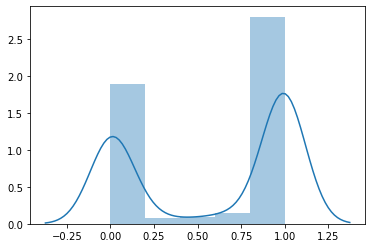

In [31]:
# code copied from the training evaluation: 
l_predictions = loaded_model.predict(val['images'])
sbn.distplot(l_predictions[:,0]);

l_predicted_label = np.argmax(l_predictions, axis=-1)
print ('accuracy:', np.mean(l_predicted_label==val['labels']))